### Imports

In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np
import struct
import time
import shutil
from decimal import Decimal
from concurrent.futures import ProcessPoolExecutor, as_completed

### Initialize parameters

In [2]:
total_num_of_weight = 401
start_time_sample = 420
end_time_sample = 4111
total_time_sample = end_time_sample - start_time_sample + 1
project_name = "protected"
true_weights = [1.43, -0.49, 0.99, -0.21, 0.12, 0.02, -0.06]
num_of_traces = 10000

### Get weight values

In [3]:
def get_weights_arr():
    weights_arr = []
    w_val = Decimal('-2.0')
    step = Decimal('0.01')
    for i in range (total_num_of_weight):
        weights_arr.append(float(w_val))
        w_val += step
    return weights_arr

weights_arr = get_weights_arr()

### Project Setup

In [4]:
proj = cw.open_project(project_name)

In [5]:
trace_waves_arr_all = []
inputs_arr = []
for trace in proj.traces:
    trace_waves_arr_all.append(trace.wave)
    inputs_arr.append(trace.textin)
print(len(trace_waves_arr_all))
print(len(inputs_arr))

trace_waves_arr_all = np.array(trace_waves_arr_all)

10000
10000


In [6]:
indices = [i for i in range(num_of_traces)]
trace_waves_arr = trace_waves_arr_all[indices,:]

In [7]:
print(len(trace_waves_arr))
print(len(trace_waves_arr[0]))

10000
24430


In [8]:
proj.close()

### Function Definitions

In [9]:
def get_hypothetical_products():
    hypothetical_products = [[] for i in range(total_num_of_weight)]
    for weight_index in range(total_num_of_weight):
        for j in range(num_of_traces):
            hypothetical_product = weights_arr[weight_index] * inputs_arr[j]
            hypothetical_products[weight_index].append(hypothetical_product)
    return np.array(hypothetical_products)

hypothetical_products = get_hypothetical_products()

In [10]:
import os, shutil
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    return

In [11]:
def float_to_binary_str(f):
    # Pack the float into 4 bytes (32-bit) using IEEE 754 standard
    [packed] = struct.unpack('!I', struct.pack('!f', f))
    # Convert the packed number to a binary string
    return f"{packed:032b}"

In [12]:
def HW_float32(f):
    # Get the binary representation of the 32-bit float
    binary_str = float_to_binary_str(f)
    # Count and return the number of '1' bits
    return binary_str.count('1')

In [13]:
def HW_byte(x):
    return bin(x).count("1")

In [14]:
#get one byte of the binary representation
def getbyte(f,byte_position):
    if byte_position == 0:
        inbinary = float_to_binary_str(f)[0]
    elif byte_position == 4:
        inbinary = float_to_binary_str(f)[25:32]
    else:
        inbinary = float_to_binary_str(f)[(byte_position-1)*8+1:byte_position*8+1]
    
    return int(inbinary,2)

In [15]:
#true byte values
true_values = [[] for i in range(5)]
def get_true_byte_values():
    for i in range(5):
        for weight_value in true_weights:
            true_values[i].append(getbyte(weight_value,i))
    return

get_true_byte_values()

In [16]:
print(true_values[0])

[0, 1, 0, 1, 0, 0, 1]


In [17]:
true_value_indices =[]
for weight_value in true_weights:
    true_value_indices.append(weights_arr.index(weight_value))
print(true_value_indices)

[343, 151, 299, 179, 212, 202, 194]


In [18]:
def get_hypothetical_hw():
    hypothetical_products_HW = [[] for i in range(total_num_of_weight)]
    for weight_index in range(total_num_of_weight):
        for j in range(num_of_traces):
            hypothetical_products_HW[weight_index].append(HW_float32(hypothetical_products[weight_index][j]))
    return np.array(hypothetical_products_HW)
                                                        
hypothetical_products_HW = get_hypothetical_hw()

In [19]:
def get_hypothetical_exponent_byte():
    hypothetical_exponent_bytes = [[] for i in range(total_num_of_weight)]
    for weight_index in range(total_num_of_weight):
        for j in range(num_of_traces):
            hypothetical_exponent_bytes[weight_index].append(HW_byte(getbyte(hypothetical_products[weight_index][j],1)))
    return np.array(hypothetical_exponent_bytes)
                                                        
hypothetical_exponent_bytes = get_hypothetical_exponent_byte()

In [20]:
def CPA_attack():
    r_abs = [[] for i in range(total_num_of_weight)]
    
    for t in range(total_time_sample):
        time_sample_index = t + start_time_sample
        if t%100 == 0:
            print("calculating for time sample " + str(time_sample_index))
        for weight_index in range(total_num_of_weight):
            corr_coef = np.corrcoef(hypothetical_products_HW[weight_index],trace_waves_arr[:,time_sample_index])[0][1]
            r_abs[weight_index].append(abs(corr_coef))
    return r_abs  

In [21]:
def recover_byte(correlation_arr, byte_position):
    correlations = [[0 for t in range(total_time_sample)] for i in range(256)]
    for weight_index in range(total_num_of_weight):#for each weight
        byte_value = getbyte(weights_arr[weight_index],byte_position)#for the chosen byte of this weight value
        for t in range(total_time_sample):#take the correlations for this weight value, for each time sample, update the correlations
            if correlation_arr[weight_index][t] > correlations[byte_value][t]:
                correlations[byte_value][t] = correlation_arr[weight_index][t]
        
    return correlations

In [22]:
def plot_correlations(correlation, value_indices):
    x = []
    total_plots = len(correlation)
    
    for t in range(total_time_sample):
        x.append(t + start_time_sample)
    
    for value_index in value_indices:
        plt.plot(x,correlation[value_index], color="r")
    
    for i in range(total_plots):
        if i in value_indices:
            continue
        else: 
            plt.plot(x,correlation[i], color="#808080")
    return

In [23]:
def savefile(filename,arr):
    f = open("correlations-protected//" + filename + ".txt", "w")
    length = len(arr)#number of columns
    
    
    #first line
    f.write("x ")
    for i in range(length):
        f.write("y"+str(i)+" ")
    f.write("\n")
    
    for t in range(total_time_sample):#for each line
        f.write(str(t+start_time_sample)+" ")#first write down the time sample
        for j in range(length):
            f.write(str(arr[j][t])+" ")
        f.write("\n")
    f.close()
    return

#### Correlations for each weight value

In [24]:
r = CPA_attack()

calculating for time sample 420
calculating for time sample 520
calculating for time sample 620
calculating for time sample 720
calculating for time sample 820
calculating for time sample 920
calculating for time sample 1020
calculating for time sample 1120
calculating for time sample 1220
calculating for time sample 1320
calculating for time sample 1420
calculating for time sample 1520
calculating for time sample 1620
calculating for time sample 1720
calculating for time sample 1820
calculating for time sample 1920
calculating for time sample 2020
calculating for time sample 2120
calculating for time sample 2220
calculating for time sample 2320
calculating for time sample 2420
calculating for time sample 2520
calculating for time sample 2620
calculating for time sample 2720
calculating for time sample 2820
calculating for time sample 2920
calculating for time sample 3020
calculating for time sample 3120
calculating for time sample 3220
calculating for time sample 3320
calculating for 

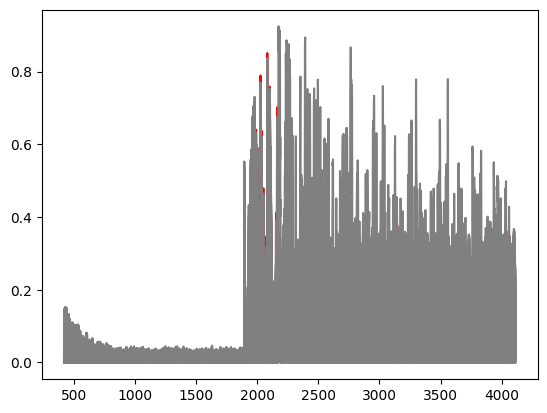

In [25]:
plot_correlations(r,true_value_indices)

#### Sign bit recovery

In [26]:
correlations_sign_bit = recover_byte(r, 0)

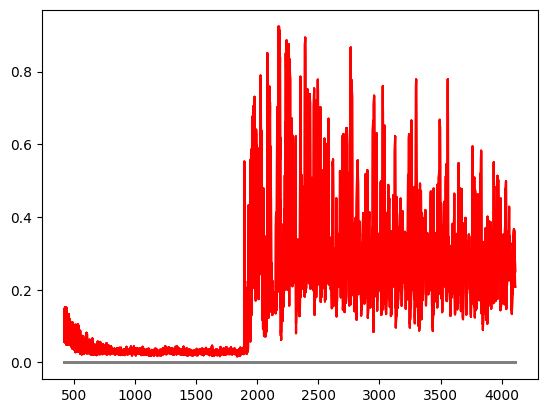

In [27]:
plot_correlations(correlations_sign_bit, true_values[0])

#### Reovery of the last 7 bits

In [28]:
correlations_byte_four = recover_byte(r, 4)

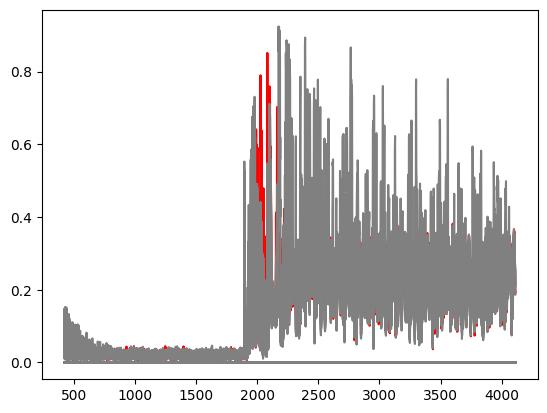

In [29]:
plot_correlations(correlations_byte_four, true_values[4])

#### Third byte recovery

In [30]:
correlations_byte_three = recover_byte(r, 3)

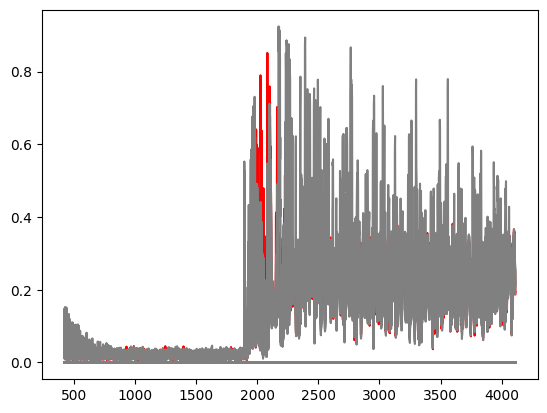

In [31]:
plot_correlations(correlations_byte_three, true_values[3])

#### Second byte recovery

In [32]:
correlations_byte_two = recover_byte(r, 2)

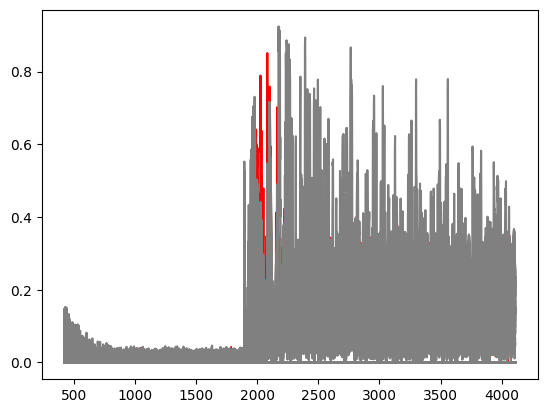

In [33]:
plot_correlations(correlations_byte_two, true_values[2])

#### Exponent byte recovery

In [34]:
correlations_exponent_byte = recover_byte(r,1)

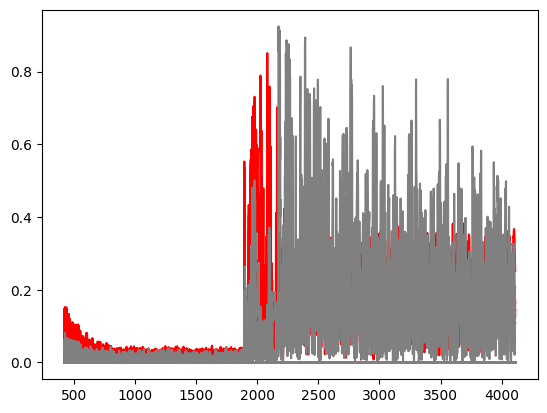

In [35]:
plot_correlations(correlations_exponent_byte, true_values[1])

In [36]:
savefile("shuffled_signbit",correlations_sign_bit)
savefile("shuffled_bytetwo",correlations_byte_two)
savefile("shuffled_bytethree",correlations_byte_three)
savefile("shuffled_bytefour",correlations_byte_four)
savefile("shuffled_exponent_byte",correlations_exponent_byte)